# MNIST classification example with TensorFlow

## Needed librairies

In [53]:
import tensorflow as tf
import tensorflow.contrib.eager as tfe
from keras.datasets import mnist
import keras
import numpy as np
import matplotlib.pyplot as plt

In [2]:
tf.__version__

'1.12.0'

In [3]:
tf.enable_eager_execution()

In [4]:
tf.executing_eagerly() 

True

## Import the Data

In [5]:
# get mnist data, split between train and test sets
# on GCP
#(x_train, y_train), (x_test, y_test) = mnist.load_data()
# with AXA network
import gzip
import sys
import _pickle as cPickle
def load_data(path):
    f = gzip.open(path, 'rb')
    if sys.version_info < (3,):
        data = cPickle.load(f)
    else:
        data = cPickle.load(f, encoding='bytes')
    f.close()
    return data
(x_train, y_train), (x_test, y_test) = load_data(path='../data/mnist.pkl.gz')

In [6]:
# check data shape (training)
x_train.shape

(60000, 28, 28)

In [7]:
# check data shape (train)
x_test.shape

(10000, 28, 28)

In [8]:
x_train.dtype, x_test.dtype

(dtype('uint8'), dtype('uint8'))

In [9]:
np.max(x_train), np.min(x_train), np.max(x_test), np.min(x_test)  

(255, 0, 255, 0)

## Normalize and reorganize the data

In [10]:
# cast uint8 -> float32
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [11]:
# renormalize the data 255 grey variation
x_train /= 255
x_test /= 255

In [12]:
# reshape the data 28 x 28 -> 784
x_train = x_train.reshape(len(x_train), x_train.shape[1]*x_train.shape[2])
x_test = x_test.reshape(len(x_test), x_test.shape[1]*x_test.shape[2])

In [13]:
x_train.shape

(60000, 784)

In [14]:
x_test.shape

(10000, 784)

## Reshape the labels

In [15]:
y_train.shape

(60000,)

In [16]:
y_test.shape

(10000,)

In [17]:
np.unique(y_train), np.unique(y_test)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8))

In [18]:
num_classes = len(np.unique(y_train))
num_classes

10

In [19]:
y_train_ = np.zeros((len(y_train), num_classes))
y_test_ = np.zeros((len(y_test), num_classes))

In [20]:
y_train_[np.arange(len(y_train)), y_train] = 1
y_test_[np.arange(len(y_test)), y_test] = 1

In [21]:
y_train=y_train_
y_test=y_test_

In [22]:
y_train.shape

(60000, 10)

In [23]:
y_test.shape

(10000, 10)

In [24]:
dim_input=x_train.shape[1]
dim_input

784

## Visualize the data

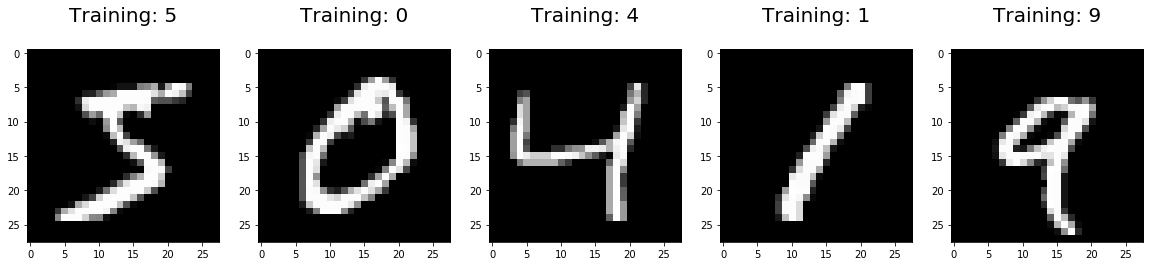

In [25]:
plt.figure(figsize=(20,4))
for index, (image, label) in enumerate(zip(x_train[0:5], y_train[0:5])):
    plt.subplot(1, 5, index + 1)
    plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
    plt.title('Training: %i\n' % np.argmax(label), fontsize = 20)

## Defined some hyperparameters

In [67]:
# learning rate
learning_rate = 0.5

# number of epoch to train our model
epochs = 10

# size of our mini batch
batch_size = 128

# hidden layer 1
n1=300

## Defined our model

In [64]:
# x [60000, 784]
# y [60000, 10]

# 1 layer n1 with 200 neurones
# n1 = 300

#  . . . . . .    input data (ffattened pixels)      x [batch    ,   dim_input]
#   \x/\x/x/      -- fully connected layer (relu)    W1[dim_input,          n1]      B1[n1         ]
#    . . .                                           Y1[batch    ,          n1]
#     \x/         -- fully connected layer (softmax) W2[n1       , num_classes]      B2[num_classes]
#      .                                             Y2[batch    , num_classes]

# reset graph before starting
tf.reset_default_graph()

# tensor (placeholder) for the learning rate: learning_rate -> not needed with Eager execution

# tensor (placeholder) for the momentum: momentum -> not needed with Eager execution

# tensor (placeholder) for the input data [60000, 784]: x -> not needed with Eager execution

# tensor (placeholder) for the output data [60000, 10]: y -> not needed with Eager execution

# now declare the weights connecting the input to the hidden layer
W1 = tf.Variable(tf.random_normal([dim_input, n1], stddev=0.03), name='W1')
b1 = tf.Variable(tf.random_normal([n1]), name='b1')
# and the weights connecting the hidden layer to the output layer
W2 = tf.Variable(tf.random_normal([n1, num_classes], stddev=0.03), name='W2')
b2 = tf.Variable(tf.random_normal([num_classes]), name='b2')

# now let's define the cost function which we are going to train the model on
# cross entropy defined manually -> need to be a function in Eager mode
# -sum(y * log(y_) + (1-y) * log(1-y_))
# need to be a function -> Eager execution
def cost(x,y): 
    
    # calculate the output of the hidden layer
    Y1 = tf.nn.relu(tf.matmul(x, W1) + b1)

    # last layer
    Ylogits= tf.matmul(Y1, W2) + b2

    # output layer
    y_ = tf.nn.softmax(Ylogits)
    
    y_clipped = tf.clip_by_value(y_, 1e-10, 0.9999999) # if value are below 1e-10 return 1e-10 same of 0.9999999
    cross_entropy = tf.reduce_sum(y * tf.log(y_clipped)+ (1 - y) * tf.log(1 - y_clipped), axis=1)
    cost = -tf.reduce_mean(cross_entropy)
    
    return cost

# add an optimiser
optimiser = tf.train.GradientDescentOptimizer(learning_rate=learning_rate) #.minimize(cost) -> not needed with Eager execution

# to add for Eager optimisa
grad=tfe.implicit_gradients(cost)

# finally setup the initialisation operator -> not needed with Eager execution

# define an accuracy assessment operation
# need to be a function -> Eager execution
def acc(x, y):
    # calculate the output of the hidden layer
    Y1 = tf.nn.relu(tf.matmul(x, W1) + b1)

    # last layer
    Ylogits= tf.matmul(Y1, W2) + b2

    # output layer
    y_ = tf.nn.softmax(Ylogits)
    # define an accuracy assessment operation
    correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    return accuracy.numpy() 

In [ ]:
cost(x,y)

In [65]:
cost(x,y).numpy()

3.890075

In [73]:
def run_logistic_model(learning_r, training_epochs, train_obs, train_labels, test_obs, test_labels, debug = False):
    cost_history = np.empty(shape=[0], dtype = float)

    for i in range(training_epochs):
        print('loss on training data {}, on test data {}'.format(cost(train_obs, train_labels).numpy(),cost(test_obs, test_labels).numpy()))
        cost_history = np.append(cost_history, cost(train_obs, train_labels).numpy())
        print('accuracy on train data', acc(train_obs, y_train))
        print('accuracy on test data', acc(test_obs, test_labels))
        optimiser.apply_gradients(grad(train_obs,  train_labels))
    return cost_history

In [ ]:
def run_logistic_model(learning_r, training_epochs, train_obs, train_labels, test_obs, test_labels, debug = False):
    sess = tf.Session()
    sess.run(init)
    
    cost_history = np.empty(shape=[0], dtype = float)

    for epoch in range(training_epochs+1):
        
        sess.run(optimiser, feed_dict = {x: train_obs, y: train_labels, learning_rate: learning_r})

        cost_ = sess.run(cross_entropy, feed_dict={x: train_obs, y: train_labels, learning_rate: learning_r})
        cost_history = np.append(cost_history, cost_)
        
        if (epoch % 100 == 0) & debug:
            print("Reached epoch",epoch,"cost J =", str.format('{0:.6f}', cost_))
            acc_train = sess.run(accuracy, feed_dict={x: train_obs, y: train_labels})
            acc_test = sess.run(accuracy, feed_dict={x: test_obs, y: test_labels})
            print(" accurary on the training set", str.format('{0:.2f}', acc_train))
            print(" accurary on the testing set", str.format('{0:.2f}', acc_test))
    return sess, cost_history

In [ ]:
cost_history = run_logistic_model(learning_r = 0.01, 
                                  training_epochs = 300, 
                                  train_obs = x_train, 
                                  train_labels = y_train, 
                                  test_obs = x_test,
                                  test_labels = y_test, 
                                  debug = True)

loss on training data 3.234933376312256, on test data 3.2358834743499756
accuracy on train data 0.15568334
accuracy on test data 0.1597
loss on training data 3.228070020675659, on test data 3.228606939315796
accuracy on train data 0.16166666
accuracy on test data 0.1657
loss on training data 3.2221291065216064, on test data 3.2223010063171387
accuracy on train data 0.16815
accuracy on test data 0.1725
loss on training data 3.21687912940979, on test data 3.216728448867798
accuracy on train data 0.17603333
accuracy on test data 0.1809
loss on training data 3.2121329307556152, on test data 3.2116916179656982
accuracy on train data 0.19006667
accuracy on test data 0.1951
loss on training data 3.2077436447143555, on test data 3.207047939300537
accuracy on train data 0.20813334
accuracy on test data 0.2172
loss on training data 3.2036099433898926, on test data 3.2026891708374023
accuracy on train data 0.22768334
accuracy on test data 0.2391
loss on training data 3.1996498107910156, on test d

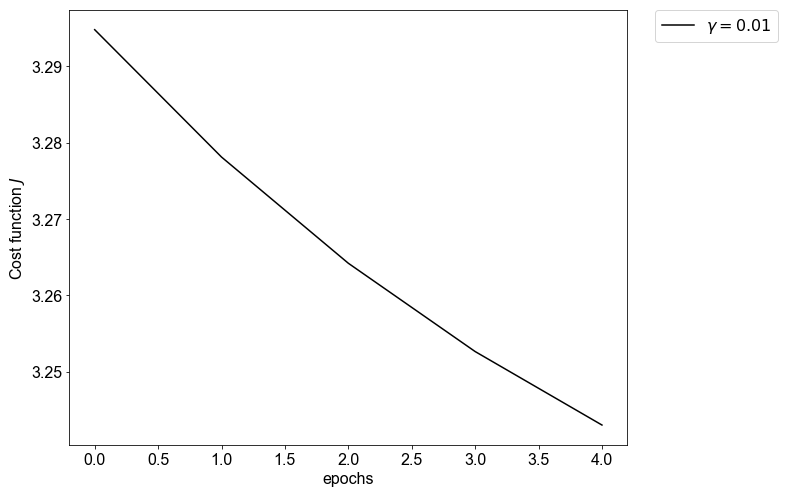

In [71]:
plt.rc('font', family='arial')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1, 1, 1)
ax.plot(cost_history, ls='solid', color = 'black', label = '$\gamma = 0.01$')
ax.set_xlabel('epochs', fontsize = 16)
ax.set_ylabel('Cost function $J$', fontsize = 16)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 16)
plt.tick_params(labelsize=16);